# Training a car to drive in a road

## section 
- libraries
- Set environment
    - Visualization: visualizeV2(road_env, car_env)
    - Road: RoadEnvironmentV2(road_function, road_width, road_length, closed)
    - Car env  CarEnvironment(road_env, n_sensors, resolution, max_sensor_range, actions)
- NN 
    - DQN: Deep Q-Network
    
- Load the traind model and show examples


- ToDo:
    - [ ] bugs
         - [x] save and load the road functoin

    - [ ] Reorgenize the setting variable
        - [ ] mode all hard coded variables to setting
        - [ ] add initial location to car reset
        - [ ] number ol layers and layes size
        
    - [ ] fix the road width in visualizeV2, noe its just taking width/2 wrt the x axis
    
    - [ ] add documentation
    
    - [ ] modify learning rates
        - [ ] epsilon
        - [ ] NN lr
    
    

In [14]:
# Numerical and Scientific Computing
import numpy as np
import math
from scipy.optimize import minimize_scalar

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Machine Learning and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Data Structures and Utilities
import random
from collections import deque
import json

# Development and Debugging
from IPython import display
import inspect

# Line road

In [ ]:
def visualize(road_env,car_env):
    """Visualize the road environment"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot center line
    center = np.array(road_env.center)
    ax.plot(center[:, 0], center[:, 1], 'w--', linewidth=1.5, label='Center')

    # Plot left edge
    left = np.array(road_env.left_edge)
    ax.plot(left[:, 0], left[:, 1], '-', color = 'gold', linewidth=2, label='Left Edge')

    # Plot right edge
    right = np.array(road_env.right_edge)
    ax.plot(right[:, 0], right[:, 1], '-', color = 'gold', linewidth=2, label='Right Edge')

    # Fill the road area
    road_polygon = np.vstack((left, right[::-1]))
    ax.fill(road_polygon[:, 0], road_polygon[:, 1], color='gray', alpha=0.3)
    
    if car_env:
        # Car location and direction as arrow
        car_loc_x = car_env.loc[0]
        car_loc_y = car_env.loc[1]
        car_dir   = car_env.direction

        arrow = plt.arrow(car_loc_x, car_loc_y, 0.2 * np.cos(car_dir), 0.2 * np.sin(car_dir), color='b', width=0.02)

        ax.add_patch(arrow)

        # Car trajectory
        trajectory = car_env.trajectory.copy()  # Get a copy of the trajectory
        if len(trajectory) > 1:  # Check if there's more than one point
            x_traj, y_traj = zip(*trajectory)  # Unpack coordinates if trajectory has points
            ax.plot(x_traj, y_traj, 'r-', linewidth=1, label='Trajectory')

    # Set plot properties
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Road Environment')
    # ax.legend(loc='upper right')
    ax.grid(True)

    # Adjust the plot limits
    all_points = np.vstack((road_env.center, road_env.left_edge, road_env.right_edge))
    margin = road_env.road_width
    ax.set_xlim(min(all_points[:, 0]) - margin, max(all_points[:, 0]) + margin)
    ax.set_ylim(min(all_points[:, 1]) - margin, max(all_points[:, 1]) + margin)

    plt.show()
    
    class RoadEnvironment:
    def __init__(self, data_points, road_width, road_length, closed):
        
        self.data_points = np.array(data_points)
        self.road_width  = road_width
        self.road_length = road_length
        self.closed      = closed
        
        self.generate_road_path()        
        
    def generate_road_path(self):
        self.center = [(0,0),(0,self.road_length)]
        self.left_edge = [(self.road_width,0),(self.road_width,self.road_length)]
        self.right_edge = [(-self.road_width,0),(-self.road_width,self.road_length)]
        
    def on_road(self,loc,direction):
        x, y = loc[0], loc[1]
        # Check road boundaries
        return not (-road_width < x < road_width and 0 <= y < road_length)

    def distans_from_center(self,loc):
        # Assuming a symmetrical road centered at x=0
        return abs(loc[0])
    
    def sensor_distanse(self, loc, direction, resolution, max_sensor_range):
        num_states = int(max_sensor_range / resolution)
        temp_loc = loc.copy()
        dis = 0
        while self.on_road(temp_loc, direction) and dis < max_sensor_range:
            temp_loc[0] += resolution * np.cos(direction)
            temp_loc[1] += resolution * np.sin(direction)
            dis += resolution
            
        sensore_state = torch.zeros(num_states)
        sensore_state[int(dis/resolution-1)] = 1
        return sensore_state

# Function road (dev)

In [44]:
def visualizeV2(road_env, car_env):
    """Visualize the non linear enviurment the road environment"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the road based on the function
    t = np.linspace(0, road_env.road_length, road_env.road_resulotion)
    road_path = road_env.road_path
    ax.plot(road_path[:, 0], road_path[:, 1], 'w--', linewidth=1.5, label='Center')

    # Calculate road edges based on road width
    road_width_half = road_env.road_width / 2
    left_edge  = road_path - np.array([road_width_half, 0])
    right_edge = road_path + np.array([road_width_half, 0])

    # Plot left and right edges
    ax.plot(left_edge[:, 0], left_edge[:, 1], '-', color='gold', linewidth=2, label='Left Edge')
    ax.plot(right_edge[:, 0], right_edge[:, 1], '-', color='gold', linewidth=2, label='Right Edge')

    # Fill the road area
    road_polygon = np.vstack((left_edge, right_edge[::-1]))
    ax.fill(road_polygon[:, 0], road_polygon[:, 1], color='gray', alpha=0.3)

    if car_env:
        # Car location and direction as arrow
        car_loc_x = car_env.loc[0]
        car_loc_y = car_env.loc[1]
        car_dir = car_env.direction

        arrow = plt.arrow(car_loc_x, car_loc_y, 0.2 * np.cos(car_dir), 0.2 * np.sin(car_dir), color='b', width=0.02)

        ax.add_patch(arrow)

        # Car trajectory
        trajectory = car_env.trajectory.copy()  # Get a copy of the trajectory
        if len(trajectory) > 1:  # Check if there's more than one point
            x_traj, y_traj = zip(*trajectory)  # Unpack coordinates if trajectory has points
            ax.plot(x_traj, y_traj, 'r-', linewidth=1, label='Trajectory')
        

    # Set plot properties
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Road Environment')
    # ax.legend(loc='upper right')
    ax.grid(True)

    # Adjust the plot limits
    all_points = np.vstack((road_path, left_edge, right_edge))
    margin = road_env.road_width / 2
    ax.set_xlim(min(all_points[:, 0]) - margin, max(all_points[:, 0]) + margin)
    ax.set_ylim(min(all_points[:, 1]) - margin, max(all_points[:, 1]) + margin)

    plt.show()


class RoadEnvironmentV2:
    def __init__(self, road_function, road_width, road_length, closed):
        
        self.road_function = road_function
        self.road_width    = road_width
        self.road_length   = road_length
        self.closed        = closed
        self.road_resulotion = 1000 # add this to setting
        
        self.generate_road_path()        
        
    def generate_road_path(self):
        t = np.linspace(0, self.road_length, self.road_resulotion)
        self.road_path = np.array([self.road_function(ti) for ti in t])
        
    def distance_from_center(self, loc):
        def distance_to_road(t):
            road_point = self.road_function(t)
            return np.linalg.norm(np.array(loc) - road_point)
        
        # Find the minimum distance
        result = minimize_scalar(distance_to_road, bounds=(0, self.road_length), method='bounded')
        return result.fun 
        
    def on_road(self, loc, direction): 
        distance = self.distance_from_center(loc)
        return distance <= self.road_width / 2
    
    def sensor_distanse(self, loc, direction, resolution, max_sensor_range):
        num_states = int(max_sensor_range / resolution)
        temp_loc = loc.copy()
        dis = 0
        while self.on_road(temp_loc,direction) and dis < max_sensor_range:
            temp_loc[0] += resolution * np.cos(direction)
            temp_loc[1] += resolution * np.sin(direction)
            dis += resolution
            
        sensore_state = torch.zeros(num_states)
        sensore_state[int(dis/resolution-1)] = 1
        return sensore_state



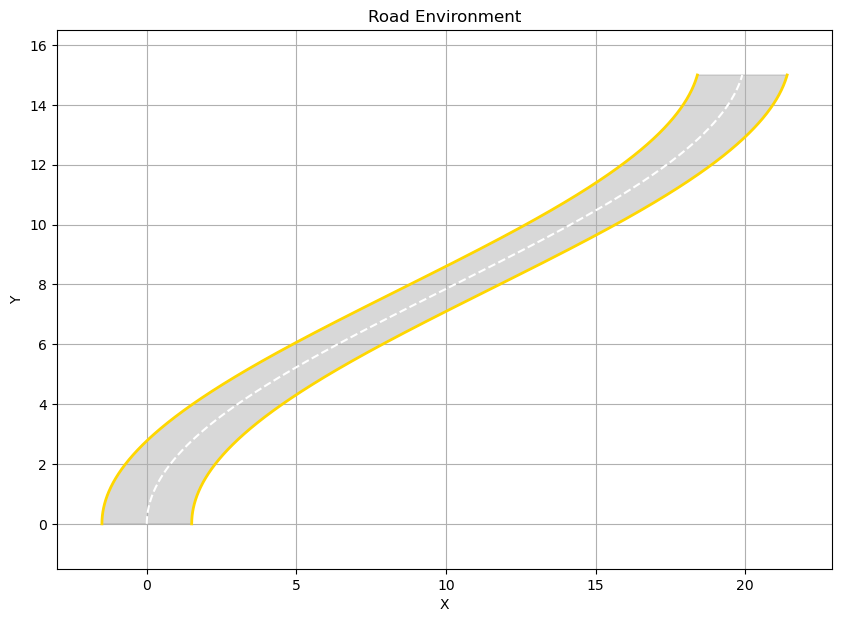

In [40]:
# example 
def road_function(x):
    return np.array([10 * (1-np.cos(0.2 * x)), x])

road_env2 = RoadEnvironmentV2(road_function, road_width = 3, road_length =15, closed =False)
visualizeV2(road_env2, car_env=None)

# Car env

In [46]:
class CarEnvironment:
    def __init__(self, road_env, n_sensors, resolution, max_sensor_range, actions):
        self.actions = actions
        self.road_env = road_env     
        
        # sensor parameters
        self.n_sensors = n_sensors
        self.resolution = resolution
        self.max_sensor_range = max_sensor_range          
        
        self.reset()
        
    def reset(self):
        self.loc       = [np.random.uniform(-.2, .2),0.2+np.random.uniform(-.2, .2)]
        self.speed     = 0.1
        self.direction = np.pi/2 + np.random.uniform(-.3, .3)
        self.Terminal = False
        self.trajectory = [self.loc.copy()]
      
    def step(self, action_number):
        action = self.actions[action_number]
        # Update car state based on action         
        self.direction += action
    
        # Move the car based on speed and direction
        dx = self.speed * np.cos(self.direction)
        dy = self.speed * np.sin(self.direction)
        self.loc[0] += dx
        self.loc[1] += dy

        self.Terminal = not self.road_env.on_road(self.loc, self.direction)
    
        # Calculate reward
        if self.Terminal:
            reward = -10 # Penalty for going off-road
            if self.loc[1] > self.road_env.road_length:
                reward = 50*(2-self.road_env.distance_from_center(self.loc)) # get to the end
        else:
            reward = (1-self.road_env.distance_from_center(self.loc)) + 30* dy # Reward for staying on road and moving forward
        self.trajectory.append(self.loc.copy())

        new_state = self.get_state()
        return new_state, reward, self.Terminal
    
    def get_state(self):
        # Get sensors readings
        sensor_readings = []
        min_dir = self.direction - np.pi / 2
        max_dir = self.direction + np.pi / 2
        directions = np.linspace(min_dir, max_dir, self.n_sensors)
        for sensor_direction in directions:
            sensor_readings.append(self.road_env.sensor_distanse(self.loc, sensor_direction , self.resolution, self.max_sensor_range))
        return torch.vstack(sensor_readings)

# Set up

[0.5888948171238565, 1.027712989905179]


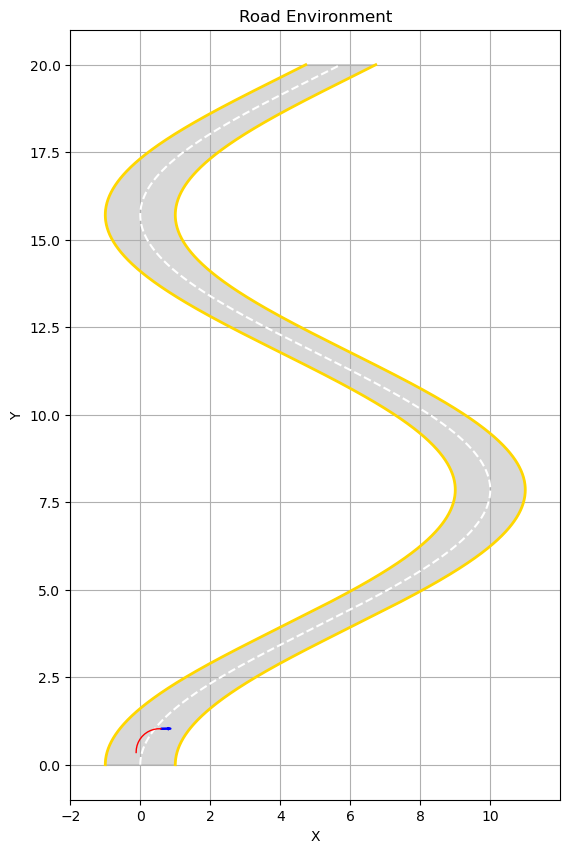

In [50]:
# Setup

# road parameters
def road_function(x):
    return np.array([5 * (1-np.cos(0.4 * x)), x])
data_points= [(0, 0), (0, 10)] # road shape
road_width=2
road_length =20
closed=False

#sensors
n_sensors = 7
resolution = .5
max_sensor_range = 5

# NN parameters
state_dim = n_sensors  * max_sensor_range / resolution   # State dimension is the number of sensor
action_dim = 5  # Actions for steering

#Actions
actions = .15*np.linspace(-1,1,action_dim)



road_env2 = RoadEnvironmentV2(road_function, road_width, road_length, False)
car_env = CarEnvironment(road_env2, n_sensors, resolution, max_sensor_range, actions)


for i in range(11):
    car_env.step(0)
print(car_env.loc)
visualizeV2(road_env2, car_env)

# NN

## DQN

Assume stereing is descrete

In [133]:
class PolicyNetwork(nn.Module):
    def __init__(self, car_env, state_dim, action_dim, train_mode, epsilon = .15):
        self.car_env = car_env
        self.train_mode = train_mode
        self.epsilon = epsilon
        self.input_dim  = int(state_dim)
        self.output_dim = int(action_dim)
        Hidden_layers = [32, 8]

        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(self.input_dim, Hidden_layers[0])
        self.fc2 = nn.Linear(Hidden_layers[0], Hidden_layers[1])
        self.fc3 = nn.Linear(Hidden_layers[1], self.output_dim)
        
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_action(self, state):
        if np.random.rand() < self.epsilon and self.train_mode: # epsilon greedy
            action = np.random.randint(self.output_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.forward(state)
            action = torch.argmax(action_values).item()
        new_state, reward, is_terminal = self.car_env.step(action)

        return state, action, reward, is_terminal, new_state

    def train(self, num_episodes, gamma = .95, alpha = .95):
        if self.train_mode:
            all_rewards = []
            fig, ax = plt.subplots(figsize=(20, 7))
            line, = ax.plot([], [])
            ax.set_xlabel('Episode')
            ax.set_ylabel('Total Reward')
            ax.set_title('Training Progress')


            optimizer = optim.Adam(self.parameters(), lr=0.005)
            # Learning rate scheduler
            # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.95)
            criterion = nn.MSELoss()

            for episode in range(num_episodes):
                if episode % 100 == 0:
                    self.epsilon = min([.9*self.epsilon,0.005])
                
                
                self.car_env.reset()
                state = self.car_env.get_state()
                total_reward = 0
                total_loss =0
                while not self.car_env.Terminal:
                    
                    state_tensor, action, reward, is_terminal, next_state = self.get_action(state)
                    # # Ensure state_tensor is 2D
                    # if state_tensor.dim() == 1:
                    #     state_tensor = state_tensor.unsqueeze(0)
                    
                    # Convert to PyTorch tensors
                    reward_tensor = torch.tensor([reward], dtype=torch.float)
                    is_terminal_tensor = torch.tensor([is_terminal], dtype=torch.float)
                    
                    # Compute Q(s,a)
                    q_values = self.forward(state_tensor)
                    q_value = q_values[0, action]
                    
                    # Compute Q(s',a') for all actions
                    with torch.no_grad():
                        next_q_values = self.forward(next_state)
                        next_q_value = next_q_values.max()
                    
                    # Compute the expected Q value
                    target_q_value = reward_tensor + gamma * next_q_value * (1 - is_terminal_tensor)
                    expected_q_values = q_values.clone()
                    expected_q_values[0, action] = q_value + alpha * (target_q_value - q_value)
                   

                    # Compute loss
                    loss = criterion(q_values, expected_q_values.detach())

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_reward += reward
                    state = next_state

                    if is_terminal:
                        break
                all_rewards.append(total_reward)
                # print(f"Episode {episode + 1}, Total Reward: {total_reward}")
                if episode % 10 == 0:
                    window_size =9
                    smoothed_data = all_rewards #np.convolve(all_rewards, np.ones(window_size), mode='same') / window_size
                    # Update the plot
                    line.set_xdata(range(len(smoothed_data)))
                    line.set_ydata(smoothed_data)
                    ax.relim()
                    ax.autoscale_view()
                    display.clear_output(wait=True)
                    display.display(fig)
                    plt.pause(0.1)

                # Save the model after training

            torch.save(self.state_dict(), 'car_policy.pth')
            print("Model saved successfully!")


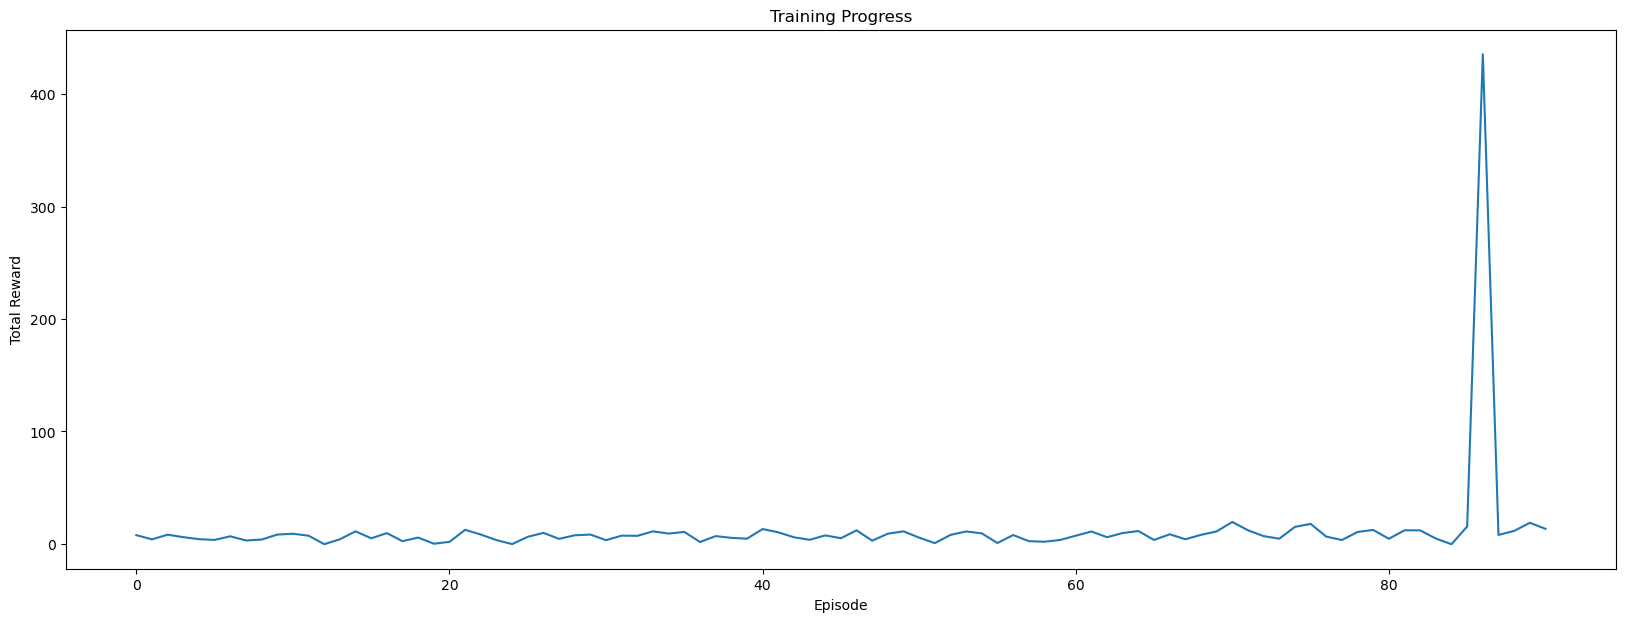

Model saved successfully!
Model trained for additional 100 episodes
Updated settings saved to 'settings.json'
Updated model saved to 'q_network_model.pth'


In [135]:
def load_existing_model_and_train():
    # Load settings
    with open('settings.json', 'r') as f:
        loaded_settings = json.load(f)

    # Recreate the road function
    exec(loaded_settings["road_function"])

    # Recreate the environment and network using loaded settings
    road_env2 = RoadEnvironmentV2(road_function, loaded_settings["road_width"], loaded_settings["road_length"], loaded_settings["closed"])
    car_env = CarEnvironment(road_env2, loaded_settings["n_sensors"], loaded_settings["resolution"], loaded_settings["max_sensor_range"], loaded_settings["Action_value"])
    state_dim = int(loaded_settings["n_sensors"] * loaded_settings["max_sensor_range"] / loaded_settings["resolution"])

    # Create a new instance of the network
    q_network = PolicyNetwork(car_env, state_dim, loaded_settings["action_dim"], train_mode=True)

    # Load the saved model parameters
    q_network.load_state_dict(torch.load('q_network_model.pth'))

    print("Settings, road function, and model loaded successfully")

    # Ask for number of episodes to train
    num_episodes = int(input("Enter the number of episodes to train: "))
    
    # Continue training
    q_network.train(num_episodes=num_episodes)

    # Update the settings with new total episodes
    loaded_settings["num_episodes"] += num_episodes

    # Save updated settings
    with open('settings.json', 'w') as f:
        json.dump(loaded_settings, f, indent=4)

    # Save the updated model
    torch.save(q_network.state_dict(), 'q_network_model.pth')

    print(f"Model trained for additional {num_episodes} episodes")
    print("Updated settings saved to 'settings.json'")
    print("Updated model saved to 'q_network_model.pth'")

    return loaded_settings, road_env2, car_env, q_network

def train_new_model():
    # Settings dictionary
    settings = {
        # "road_function": inspect.getsource(road_function),
        "road_function": "def road_function(x):\n    return np.array([5 * (1-np.cos(0.4 * x)), x])",
        "road_width": 2,
        "road_length": 20,
        "closed": False,
        "n_sensors": 5,
        "resolution": 0.2,
        "max_sensor_range": 3,
        "action_dim": 3,
        "num_episodes": 200,
        "Action_value_scaling": 0.2 
    }
    # Now calculate Action_value using the action_dim from settings
    Action_value = settings["Action_value_scaling"] * np.linspace(-1, 1, settings["action_dim"])
    # Add Action_value to settings
    settings["Action_value"] = Action_value.tolist() 

    # Use settings from the dictionary
    road_env2 = RoadEnvironmentV2(road_function, settings["road_width"], settings["road_length"], settings["closed"])



    car_env = CarEnvironment(road_env2, settings["n_sensors"], settings["resolution"], settings["max_sensor_range"], settings["Action_value"])
    state_dim = int(settings["n_sensors"] * settings["max_sensor_range"] / settings["resolution"])

    # Create an instance of your QNetwork
    q_network = PolicyNetwork(car_env, state_dim, settings["action_dim"], train_mode=True)

    # Train the network
    q_network.train(num_episodes=settings["num_episodes"])

    # Save settings to JSON file
    with open('settings.json', 'w') as f:
        json.dump(settings, f, indent=4)

    # Save the model
    torch.save(q_network.state_dict(), 'q_network_model.pth')

    print("Settings saved to 'settings.json'")
    print("Model saved to 'q_network_model.pth'")
    
    return settings, road_env2, car_env, q_network

# Ask user whether to load existing data or train new model
user_choice = input("Do you want to load existing data and continue training (L) or train a new model (T)? ").strip().lower()

if user_choice == 'l':
    settings, road_env, car_env, q_network = load_existing_model_and_train()
elif user_choice == 't':
    settings, road_env, car_env, q_network = train_new_model()
else:
    print("Invalid choice. Exiting.")
    exit()

# run model

 action = 2
 action = 2
 action = 0
Episode finished early
Test Episode 1, Trajectory length: 4


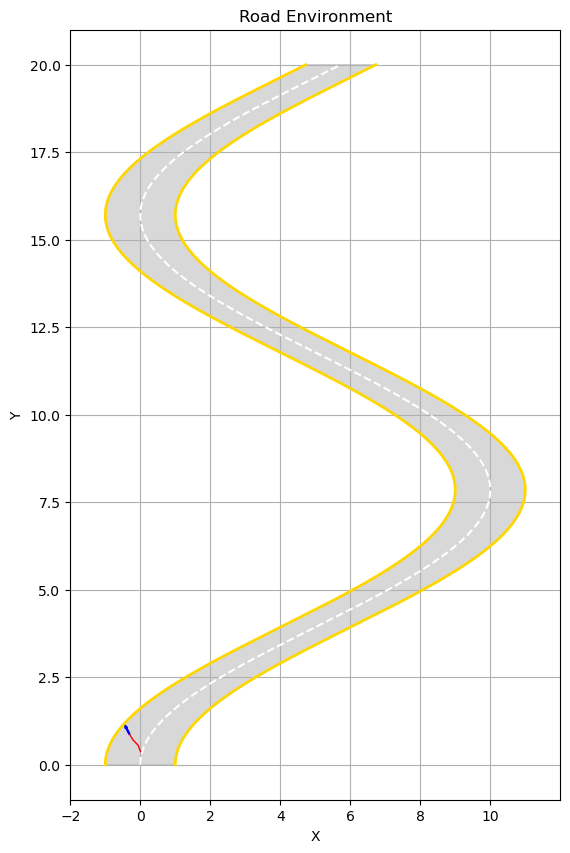

In [137]:
# run model with loading the setting 

def load_settings(filename='settings.json'):
    with open(filename, 'r') as f:
        return json.load(f)

def run_episode(car_env, agent, max_steps):
    car_env.reset()  # Reset the environment at the start of each episode
    trajectory = [car_env.loc.copy()]
    for _ in range(max_steps):
        state = car_env.get_state()
        _, action, _, _, _ = agent.get_action(state)
        print(f' action = {action}')
        _, reward, done = car_env.step(action)
        trajectory.append(car_env.loc.copy())
        if done:
            print("Episode finished early")
            break
    return trajectory

def run_model():
    # Load settings
    settings = load_settings()

    # Recreate the road function
    exec(settings["road_function"])

    # Create environments
    road_env = RoadEnvironmentV2(
        road_function, 
        settings["road_width"], 
        settings["road_length"], 
        settings["closed"]
    )
        
    car_env = CarEnvironment(
        road_env, 
        settings["n_sensors"], 
        settings["resolution"], 
        settings["max_sensor_range"], 
        settings["Action_value"]
    )

    # Calculate state dimension
    state_dim = int(settings["n_sensors"] * settings["max_sensor_range"] / settings["resolution"])

    # Load the saved model
    loaded_agent = PolicyNetwork(car_env, state_dim, settings["action_dim"], train_mode=False)
    loaded_agent.load_state_dict(torch.load('q_network_model.pth'))
    loaded_agent.eval()  # Set the network to evaluation mode

    # Run and visualize test episodes
    num_test_episodes = 1
    max_steps = 200

    for episode in range(num_test_episodes):
        trajectory = run_episode(car_env, loaded_agent, max_steps)
        print(f"Test Episode {episode + 1}, Trajectory length: {len(trajectory)}")
        
        # Update car_env's trajectory for visualization
        car_env.trajectory = trajectory
        
        visualizeV2(road_env, car_env)

run_model()

## DDPG

In [ ]:
https://www.youtube.com/watch?v=ljHwbY9QrJU

In [ ]:
# actor

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 
    
# critic

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 

In [ ]:



class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 

class Agent:
    def __init__(self, state_dim, action_dim, lr=0.001):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.state_dim = state_dim
        self.action_dim = action_dim

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.policy(state)
        return action.item(), torch.log(torch.abs(action) + 1e-8)  # Return action and log probability

    def update(self, rewards, log_probs):
        returns = self.compute_returns(rewards)
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    def compute_returns(self, rewards, gamma=0.99):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

def train(env, agent, num_episodes, max_steps):
    all_rewards = []
    fig, ax = plt.subplots(figsize=(10, 5))
    line, = ax.plot([], [])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Training Progress')
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []

        for step in range(max_steps):
            action, log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = next_state

        agent.update(rewards, log_probs)
        all_rewards.append(episode_reward)

        if episode % 100 == 0:
            # print(f"Episode {episode}, Total Reward: {episode_reward}")
            # Update the plot
            line.set_xdata(range(len(all_rewards)))
            line.set_ydata(all_rewards)
            ax.relim()
            ax.autoscale_view()
            display.clear_output(wait=True)
            display.display(fig)
            plt.pause(0.1)


    return all_rewards         
            
# Setup and training

n_sensors = 5  # Number of sensors
state_dim = n_sensors  # State dimension is the number of sensors
action_dim = 1  # Action dimension is 1 for steering

road_env = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =10, closed=False, resolution=0.1)
car_env = CarEnvironment(road_env,n_sensors)



agent = Agent(state_dim, action_dim)
num_episodes = 1000
max_steps = 200

try:
    all_rewards = train(car_env, agent, num_episodes, max_steps)
    # Save the trained model
    torch.save(agent.policy.state_dict(), 'car_policy.pth')
    print("Model saved successfully!")
    # Final plot
    plt.figure(figsize=(12, 6))
    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()
    
    
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Current state: {car_env._get_state()}")
    print(f"Car location: {car_env.car_state['location']}")
    print(f"Car direction: {car_env.car_state['direction']}")
    print(f'CarEnv = {car_env.trajectory}')

visualize(road_env,car_env)

# Train

# Test

In [146]:
def run_episode(env, agent, max_steps):
    state = env.reset()
    done = False
    total_reward = 0
    trajectory = [env.car_state["location"].copy()]

    for _ in range(max_steps):
        action, _ = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        trajectory.append(env.car_state["location"])

        if done:
            break

        state = next_state

    return trajectory, total_reward

In [147]:
# Load the saved model
loaded_agent = Agent(state_dim, action_dim)
loaded_agent.policy.load_state_dict(torch.load('car_policy.pth'))
loaded_agent.policy.eval()  # Set the network to evaluation mode

n_sensors = 5  # Number of sensors
state_dim = n_sensors  # State dimension is the number of sensors
action_dim = 1  # Action dimension is 1 for steering

road_env = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =15, closed=False, resolution=0.1)
car_env = CarEnvironment(road_env,n_sensors)

# Run and visualize test episodes
num_test_episodes = 5
max_steps = 20

for episode in range(num_test_episodes):
    trajectory, total_reward = run_episode(car_env, loaded_agent, max_steps)
    print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
    visualize(RoadEnv,CarEnv)




NameError: name 'Agent' is not defined

In [ ]:
RoadEnv = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =15, closed=False, resolution=0.1)
CarEnv  = CarEnvironment(RoadEnv,n_sensors =5)
car_agent = CarAgent()



while not CarEnv.Terminal:
    action = car_agent.act(CarEnv.car_state)
    CarEnv.step(action)


print(f'CarEnv = {CarEnv.trajectory}')
visualize(RoadEnv,CarEnv)

In [ ]:
random.uniform(-.4, .4)+np.pi/2 

In [ ]:
x = np.linspace(-1,1,10)
for i in x:
    print((5*(1-abs(i)))**2)